# Lecture 3: Probability and Statistics in Practice

10 Apr, 2023

## Recap of the last time: Binomial cont-d

Koopmans (1950) and Ernesto San Martin (2011) formalize the below intuition quite well, but additional insights from Richard McElreath (2021) are needed, in order to link the statistics to the scientific models.

$$
S = (F(\Lambda), \phi(\Lambda, y))
$$

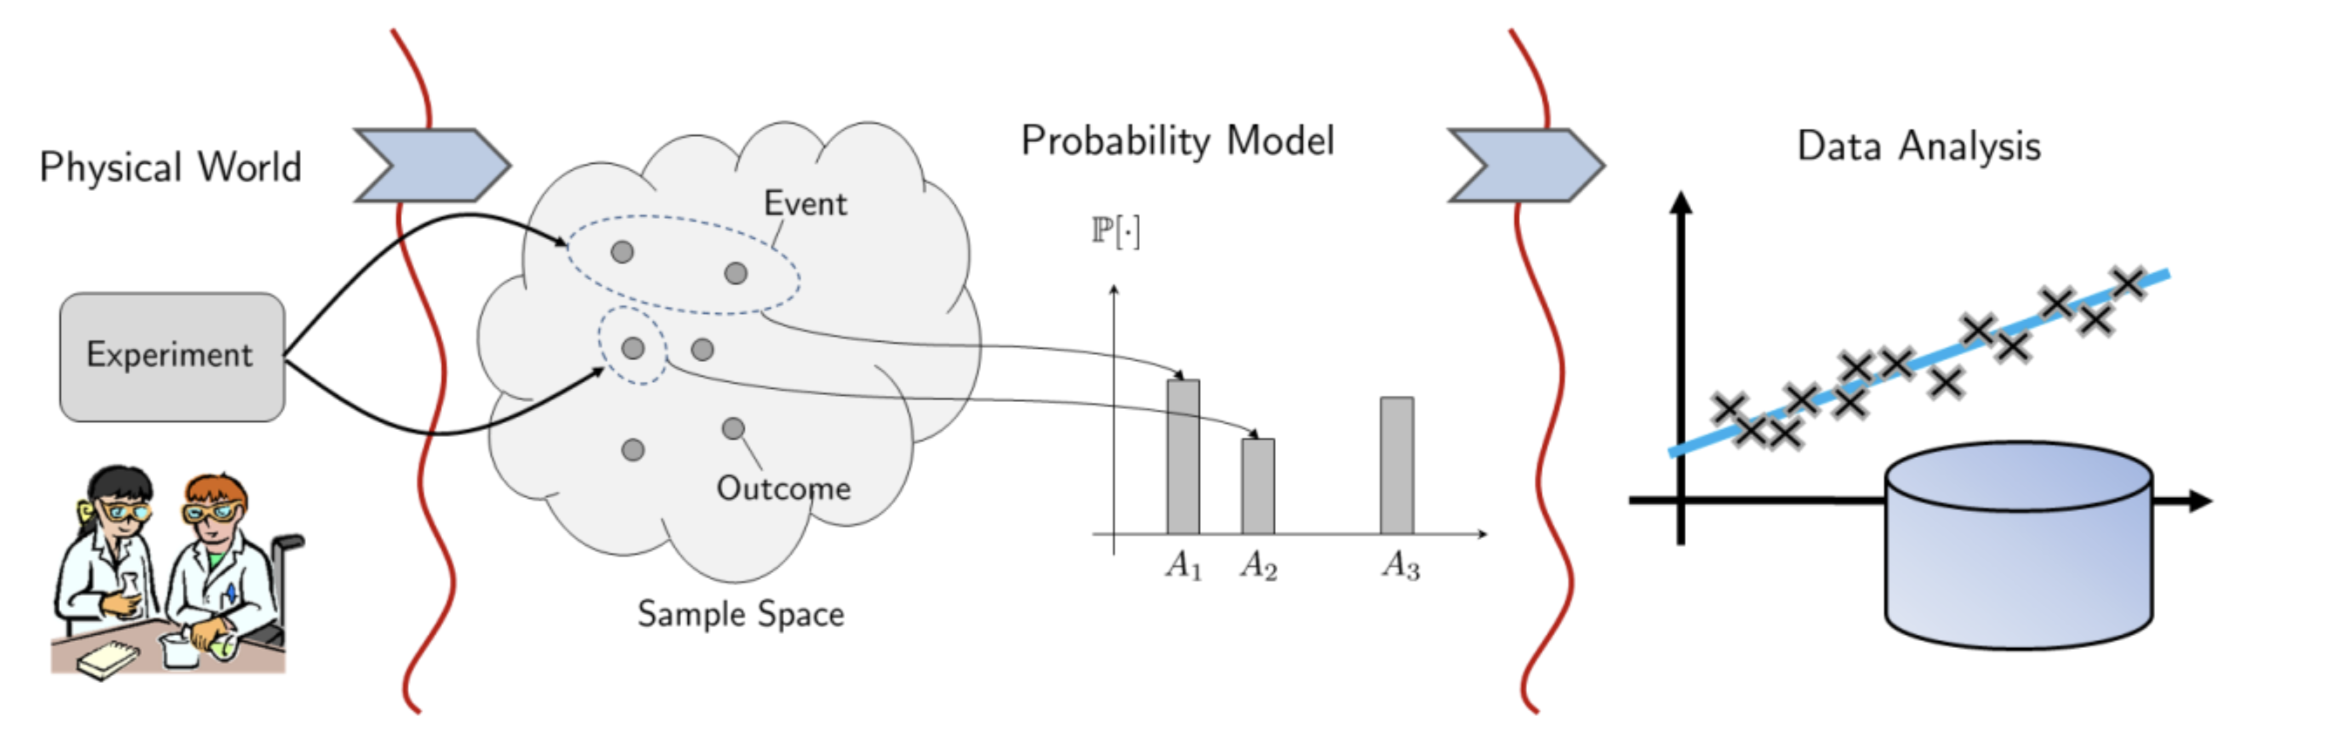

Source: probability4datascience.com


### The story of the course

- "Theory" and Stories: **conceptual understanding**
    - Understanding the problems and domains we apply the tools to
    - Understanding the tools we use and how they compose (math, prob, stats, ML)
    - Understand the software engineering choices we make and good practices
    - Understand methodology - what are the processes we follow in different contexts and roles
    - Reflections and philosophy
    - Be able to formulate a problem, make the right choices, iterate ...
- Simulation: safe sandbox - prove something works in principle, play!
- Modeling and working with data (eda, visualization, wrangling)
- Engineering: build useful and high-quality software


<details>
  <summary>The map of the adventure</summary>
  
![image.png](attachment:image-2.png)

</details>

In [1]:
%load_ext autoreload
%autoreload 2

In [201]:
from numpy.typing import ArrayLike
from typing import Literal

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import graphviz as gr
from IPython.core.pylabtools import figsize
plt.style.use("ggplot")

rng = np.random.default_rng(seed = 111) 

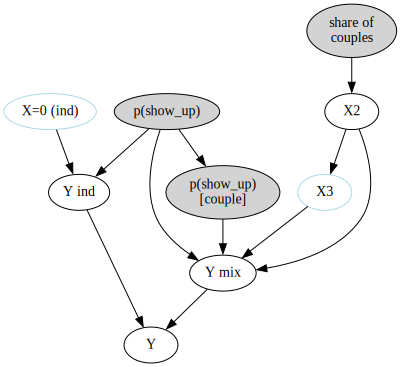

In [3]:
g = gr.Digraph()

g.edge("X2", "X3")
g.edge("X=0 (ind)", "Y ind")
g.edge("Y ind", "Y")
g.edge("X3", "Y mix")
g.edge("X2", "Y mix")
g.edge("Y mix", "Y")
g.node("p(show_up)", fillcolor="lightgrey", style="filled")
g.node("p(show_up)\n[couple]", fillcolor="lightgrey", style="filled")
g.edge("p(show_up)", "Y ind")
g.edge("p(show_up)", "Y mix")
g.edge("p(show_up)", "p(show_up)\n[couple]")
g.edge("p(show_up)\n[couple]", "Y mix")
g.node("share of \n couples", fillcolor="lightgrey", style="filled")
g.edge("share of \n couples", "X2")

g.node("X3", color="lightblue")
g.node("X=0 (ind)", color="lightblue")

g

In [21]:
def compute_nr_passengers(
    p_showup: float, 
    p_couple: float, 
    nr_seats: int = 3,
    nr_samples: int | tuple[int, int] = 5000,
) -> pd.DataFrame:
    """A function which simulates how many passengers will show up to a safari 
    or flight, if there are only 3 spots on the plane / car.

    Arguments:
        * p_showup: probability that each individual will keep the promise
        * p_couple: probability that a person will bring a (+1) - attention,
            the narrative is that one reserves the spot and drags another,
            so p_couple in the population isn't what will end up on the plane
        * nr_seats: if you want, think about how to deneralize this - do not use!
        * nr_samples: you could use something more realistic, of a few years 
            being in business -- there will be more uncertainty
    """
    if not (0 <= p_showup <= 1 or 0 <= p_couple <= 1):
        raise ValueError("The parameters should be in [0, 1] range")
    rng = np.random.default_rng(seed = 1317)
    p_couple_reservation = (1 - (1 - p_couple)**2)

    df = pd.DataFrame({
        "third_wheel": rng.binomial(1, p_couple_reservation, size = nr_samples),
        "y_individuals": rng.binomial(nr_seats, p_showup, size = nr_samples),
        "y_mix": (
            rng.binomial(1, p_showup, size = nr_samples) + 
            2*rng.binomial(1, p_showup**2, size = nr_samples)
        ),
    }).assign(
        nr_show_up = (
            lambda df_: 
            df_.third_wheel*df_.y_mix + 
            (1 - df_.third_wheel) * df_.y_individuals
        )
    )

    return df

In [22]:
df = compute_nr_passengers(0.85, p_couple=0.6)
(df
 .groupby("third_wheel")
 .agg({
    'nr_show_up': ['mean'], 
    'third_wheel': ['count']
 })
 .round(2)
 .droplevel(axis=1, level=0)
 .reset_index()
 .rename(columns={"mean": "avg_nr_showup"})
)

third_wheel  avg_nr_showup  count
0            0           2.55    822
1            1           2.29   4178

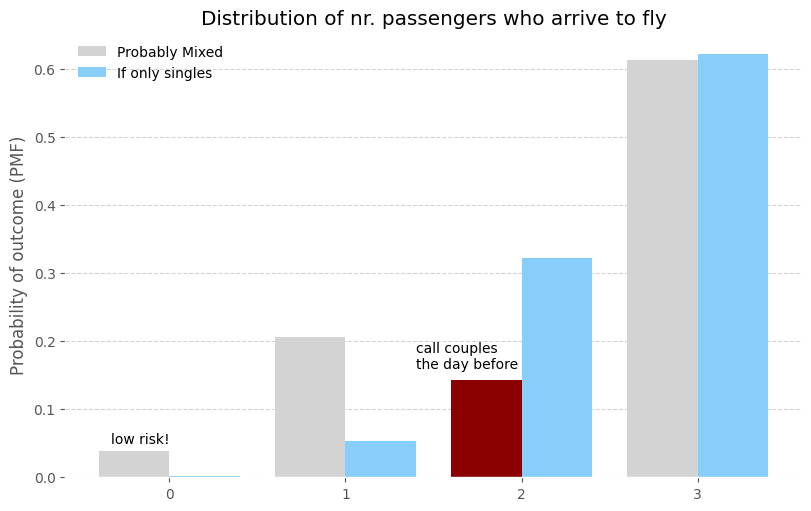

In [23]:
show_up_pmf = df.nr_show_up.value_counts() / df.nr_show_up.value_counts().sum()
show_up_ind, show_up_ind_counts = np.unique(
    rng.binomial(n=3, p=0.85, size = 5000), return_counts=True
)
show_up_ind_pmf = show_up_ind_counts / show_up_ind_counts.sum()

fig, ax = plt.subplots(figsize = (8, 5), layout="constrained")
_ = ax.set_title("Distribution of nr. passengers who arrive to fly")

offset, width = 0.2, 0.4
color_array = ["darkred" if i == 2 else "lightgrey" for i in show_up_pmf.index]
ax.bar(x=show_up_pmf.index - offset , height=show_up_pmf, 
       color=color_array, width = width, label = "Probably Mixed")
ax.bar(x=show_up_ind + offset, height=show_up_ind_pmf, 
       width = width, color="lightskyblue", label = "If only singles")

ax.annotate("low risk!", xytext=(-0.33, 0.05), xy = (0, 0.02))
ax.annotate("call couples \nthe day before", xytext=(1.4, 0.16), xy = (1.5, 0.15))

ax.tick_params(bottom='on', labelbottom='on')

ax.xaxis.tick_bottom()
ax.set_xticks(range(0, 4))
ax.yaxis.grid(True, color="lightgrey", linestyle="--")

ax.set_ylabel("Probability of outcome (PMF)")
fig.set_facecolor("white")
ax.legend(loc='best', frameon=False) #, ncol = 1, bbox_to_anchor=(1.3, 0.6), )

ax.set_facecolor("white")


In [8]:
def flip_coins(
        nr_flips: int = 500, 
        p: float = 0.5, 
        rng: np.random.Generator = rng, 
    ) -> pd.DataFrame:
    """Returns a DataFrame with two columns:
        - experiment_nr: autoincrement
        - outcome: {1, 0} of the coin flip
    """
    df = pd.DataFrame({
        "experiment_nr": range(1, nr_flips + 1),  
        "outcome": rng.choice(
            a = [1, 0], 
            size = nr_flips, 
            p = [p, 1-p],
        ),
    })
    
    return df.assign(
        heads_proportion = df.outcome.cumsum() / df.experiment_nr
    )

p_heads = 0.3
df = flip_coins(500, p_heads, rng)
df.head()

experiment_nr  outcome  heads_proportion
0              1        1          1.000000
1              2        0          0.500000
2              3        0          0.333333
3              4        0          0.250000
4              5        1          0.400000

In [24]:
from decision_making.simulator import (
    simulate_rv_convergence, plot_rv_convergence
)

In [25]:
res = simulate_rv_convergence(
    dist = "poisson", 
    n = int(1e5), 
    parameters = {"lam": 4.5}
)
res.keys()

dict_keys(['partial_average', 'sample_sizes', 'mse', 'variance', 'parameter'])

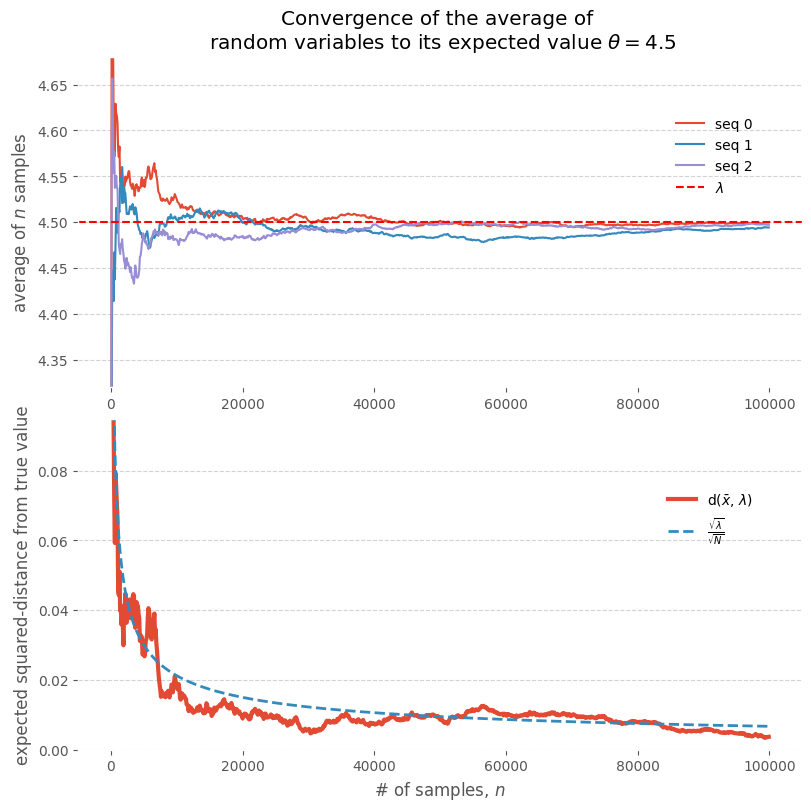

In [33]:
plot_rv_convergence(res)

In [34]:
res_bern = simulate_rv_convergence(
    dist = "binomial", 
    n = int(1e5), 
    parameters = {"p": 0.55, "n": 1}
)
res_bern.keys()

dict_keys(['partial_average', 'sample_sizes', 'mse', 'variance', 'parameter'])

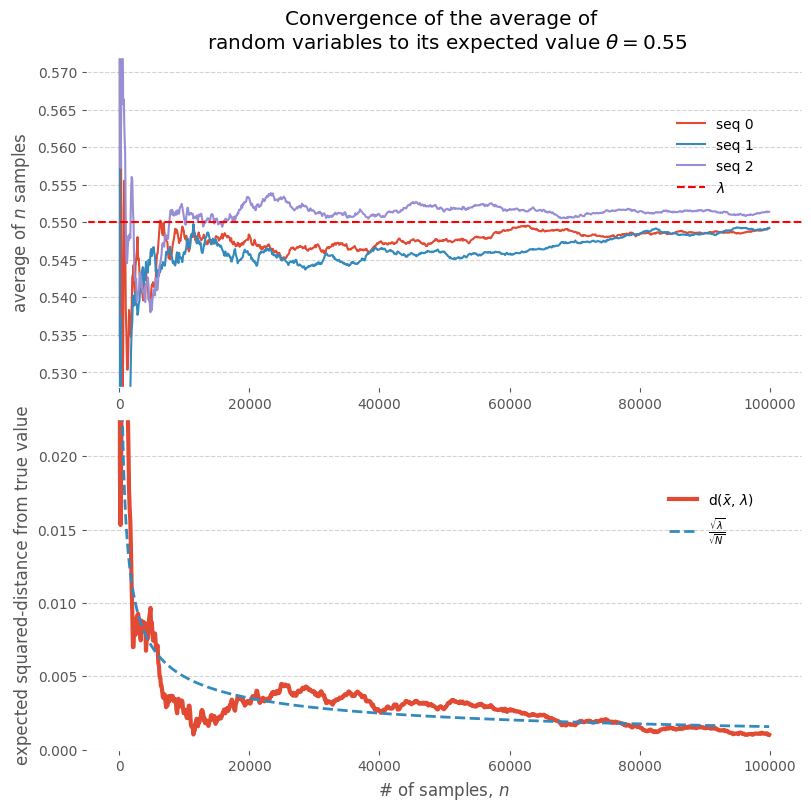

In [35]:
plot_rv_convergence(res_bern)

In [36]:
res_binom = simulate_rv_convergence(
    dist = "binomial", 
    n = int(1e5), 
    parameters = {"p": 0.40, "n": 25} # as in a basketball game
)
res_bern.keys()

dict_keys(['partial_average', 'sample_sizes', 'mse', 'variance', 'parameter'])

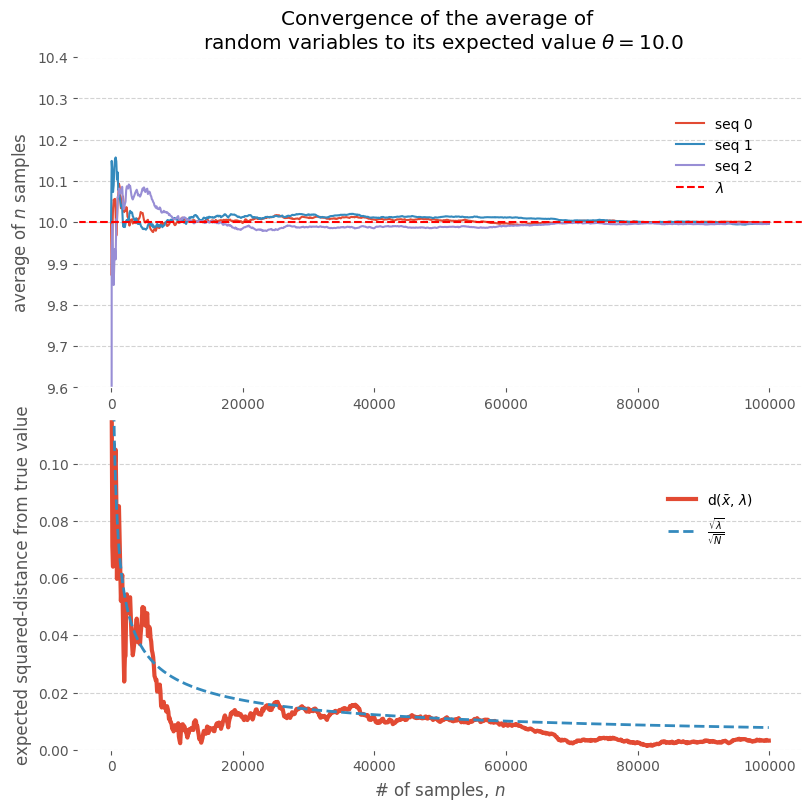

In [37]:
plot_rv_convergence(res_binom)

There is so much to learn about probability, and it could be so much fun, if we look at it as storytelling through DAGs.

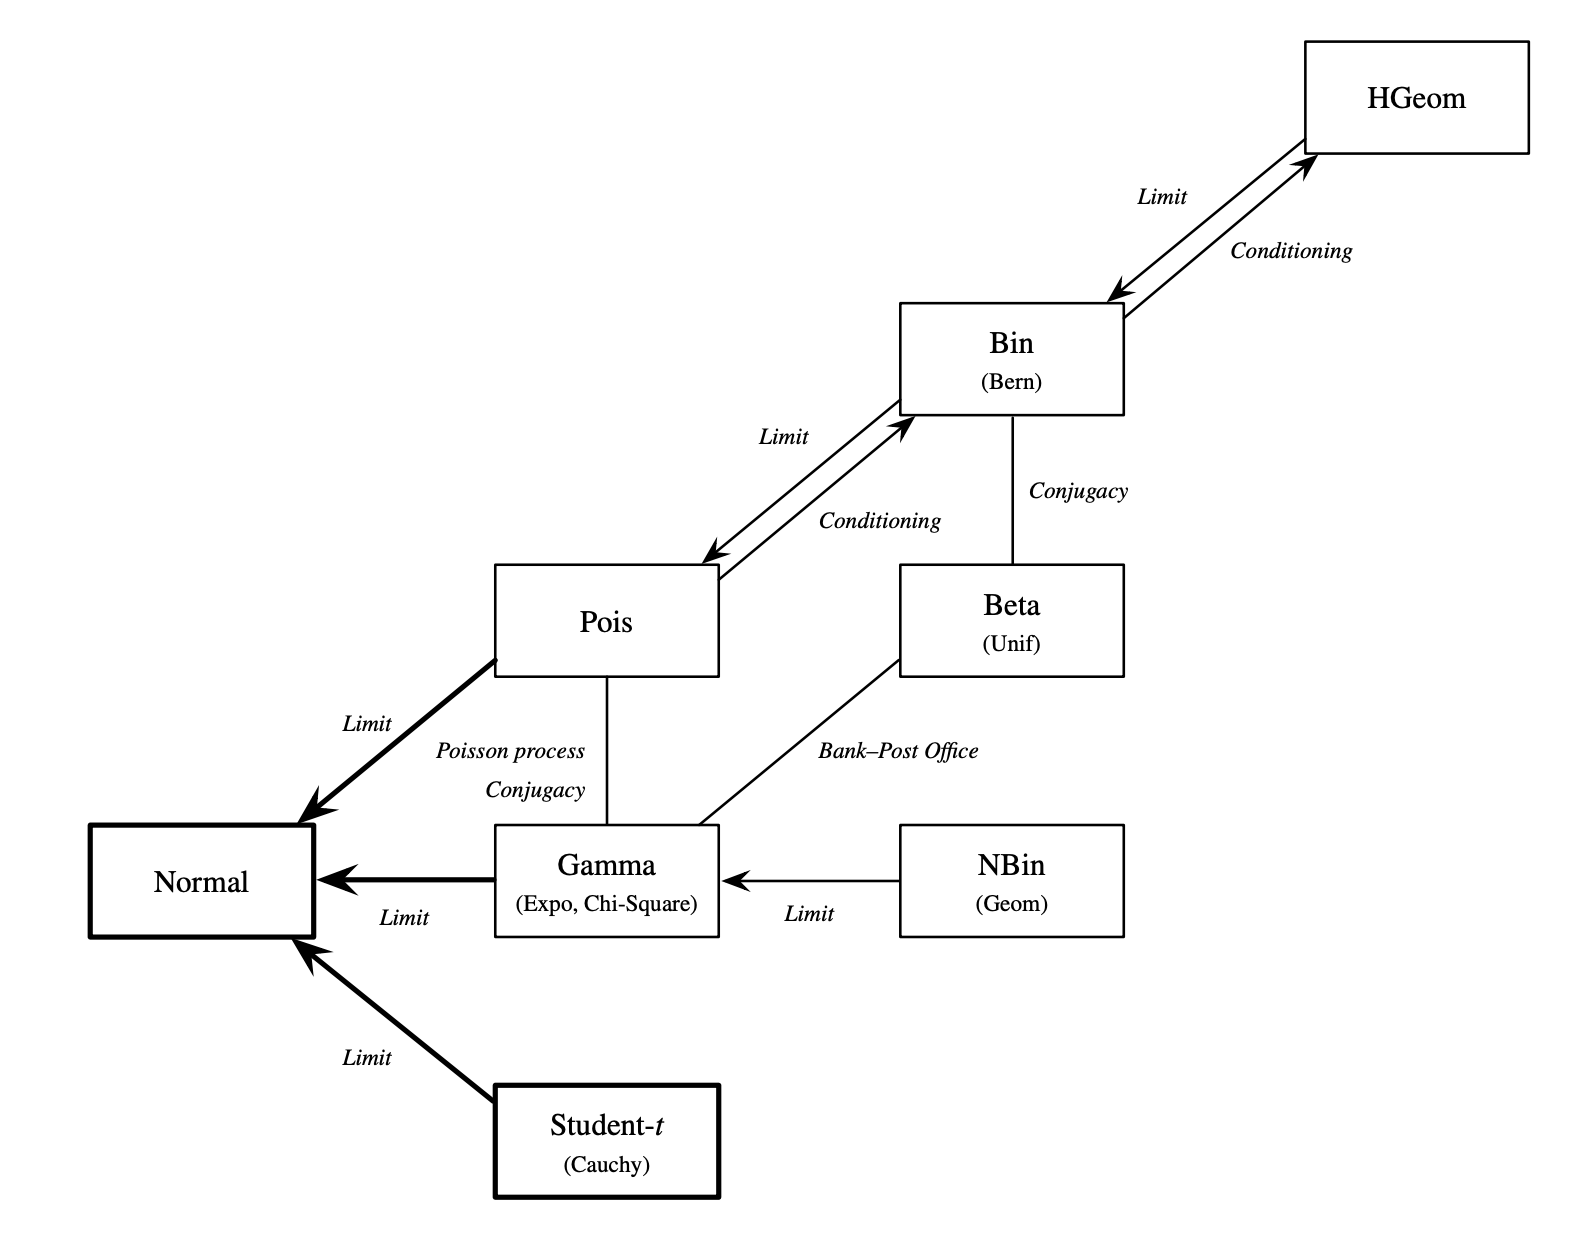

Source: Joe Blitzstein (Probability 110)

<details>
  <summary>Exponential family: Richard McElreath (Rethinking, 2021)</summary>

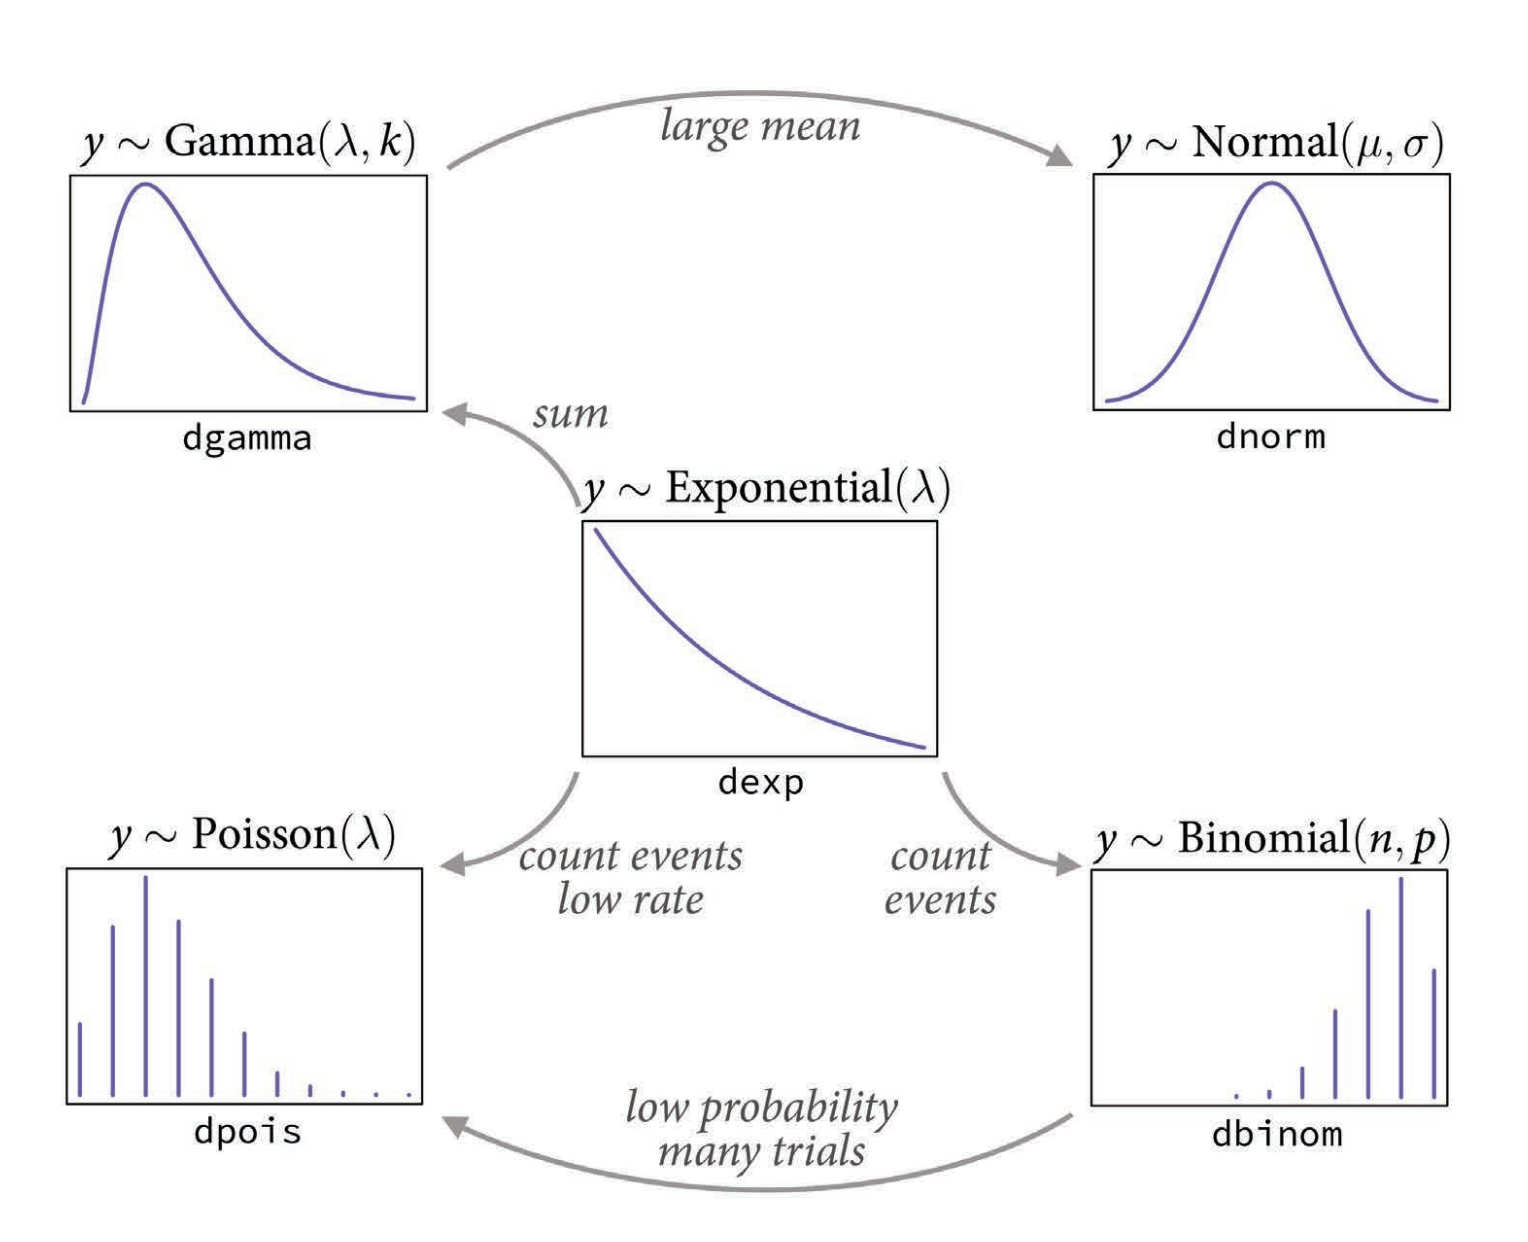
</details>


## Some graphs, Bayes, and more probability

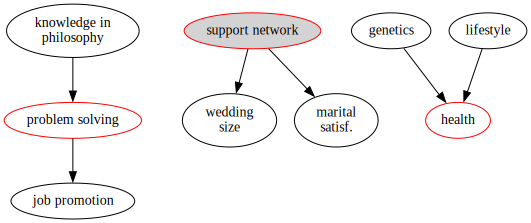

In [7]:
g = gr.Digraph()

g.edge("knowledge in \n philosophy", "problem solving")
g.edge("problem solving", "job promotion")
g.node("problem solving", color = "red")

g.edge("support network", "wedding \n size")
g.edge("support network", "marital \n satisf.")
g.node("support network", color = "red", fillcolor="lightgrey", style="filled")


g.edge("genetics", "health")
g.edge("lifestyle", "health")
g.node("health", color = "red")

g

A path is blocked if and only if:
- It contains a non collider that has been conditioned on
- It contains a collider that has not been conditioned on 
    - and has no descendants that have been conditioned on.

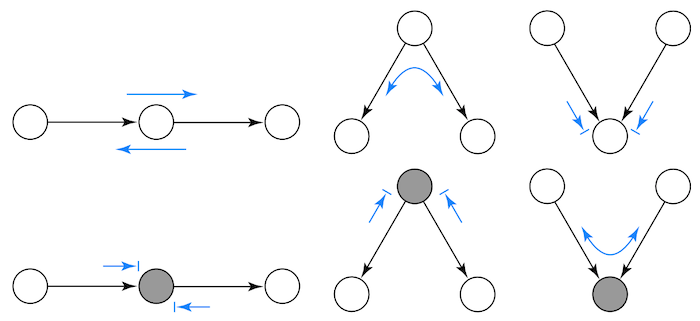

this is the old probability tree again!


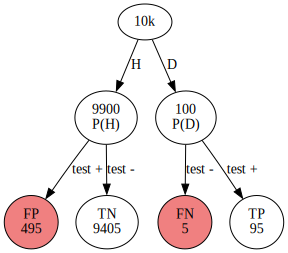

In [79]:
g = gr.Digraph()

g.edge("10k", "9900\nP(H)", label="H")
g.edge("9900\nP(H)", "FP\n495", label="test +")
g.edge("9900\nP(H)", "TN\n9405", label="test -")
g.node("FP\n495", fillcolor="lightcoral", style="filled")

g.edge("10k", "100 \nP(D)", label="D", )
g.edge("100 \nP(D)", "FN\n5", label="test -")
g.edge("100 \nP(D)", "TP\n95", label="test +")
g.node("FN\n5", fillcolor="lightcoral", style="filled")

print("this is the old probability tree again!")
g

In [107]:
def inverse_probability(
    observed_value: int, 
    p_prior: float | None = None, 
    true_positive_rate  = 0.95, # sensitivity, tnr = specificity
    true_negative_rate  = 0.9,
) -> float | ArrayLike:
    """We will apply this both to medical testing and test-driven development"""
    p_prior_ = np.linspace(0, 1, 50) if p_prior is None else p_prior
        
    likelihood = true_positive_rate if (x := observed_value) else 1 - true_positive_rate
    false_positive_rate = 1 - true_negative_rate
    prob_x_given_not_p = false_positive_rate if (x := observed_value) else true_negative_rate
    posterior = ( 
        p_prior_ * likelihood /
        (p_prior_ * likelihood +  (1 - p_prior_) * prob_x_given_not_p)
    )
    return round(posterior, 2) if  isinstance(posterior, float) else posterior

In [108]:
pr_rare_disease = inverse_probability(1, 0.01, true_negative_rate=0.95, true_positive_rate=0.95)
print(
    'Updating the probability of a rare disease, given a positive test',
    pr_rare_disease
)

print(
    'Updating the probability of a rare disease, given a second positive test',
    inverse_probability(1, pr_rare_disease, true_negative_rate=0.95, true_positive_rate=0.95)
)

Updating the probability of a rare disease, given a positive test 0.16
Updating the probability of a rare disease, given a second positive test 0.78


In [111]:
print("Let's say I nailed 10 test cases in a row, how confident I am there are still bugs?")
tpr, tnr = 0.5, 0.7
posteriors_, p = [], 0.4
for i in range(10):
    p = inverse_probability(1, p_prior=p, true_negative_rate=tnr, true_positive_rate=tpr)
    posteriors_.append(p)
    print(f"After {i} passed tests: P(A|X) = {p}")

Let's say I nailed 10 test cases in a row, how confident I am there are still bugs?
After 0 passed tests: P(A|X) = 0.53
After 1 passed tests: P(A|X) = 0.65
After 2 passed tests: P(A|X) = 0.76
After 3 passed tests: P(A|X) = 0.84
After 4 passed tests: P(A|X) = 0.9
After 5 passed tests: P(A|X) = 0.94
After 6 passed tests: P(A|X) = 0.96
After 7 passed tests: P(A|X) = 0.98
After 8 passed tests: P(A|X) = 0.99
After 9 passed tests: P(A|X) = 0.99


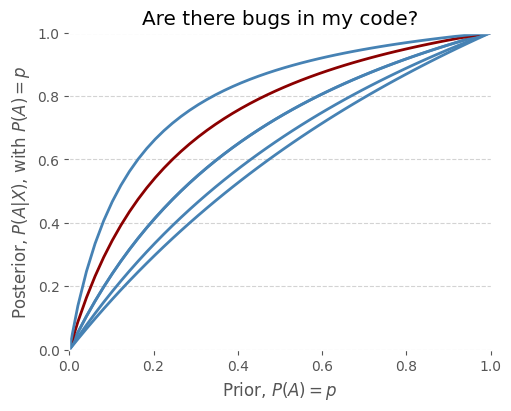

In [156]:
p = np.linspace(0, 1, 50)

seq_test_results = [1, 1, 1, 0, 1, 1]
colors = ["steelblue", "steelblue", "steelblue", "darkred", "steelblue", "steelblue"]
posteriors_ = []
for idx, x in enumerate(seq_test_results):
    if idx == 0:
        y = inverse_probability(seq_test_results[idx], true_negative_rate=tnr, true_positive_rate=tpr)
        posteriors_.append(y)
    y = inverse_probability(
        seq_test_results[idx], 
        p_prior = posteriors_[idx-1], 
        true_negative_rate=tnr, 
        true_positive_rate=tpr
    )
    posteriors_.append(y)

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')
fig.set_facecolor("white")

for idx in range(6):
    ax.plot(p, posteriors_[idx], lw=2, color = colors[idx])

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Prior, $P(A) = p$")
    ax.set_ylabel("Posterior, $P(A|X)$, with $P(A) = p$")
    ax.yaxis.grid(True, color="lightgrey", linestyle="--")
    ax.yaxis.grid(True, color="lightgrey", linestyle="--")
    ax.set_facecolor("white")
    ax.set_facecolor("white")

plt.title("Are there bugs in my code?");


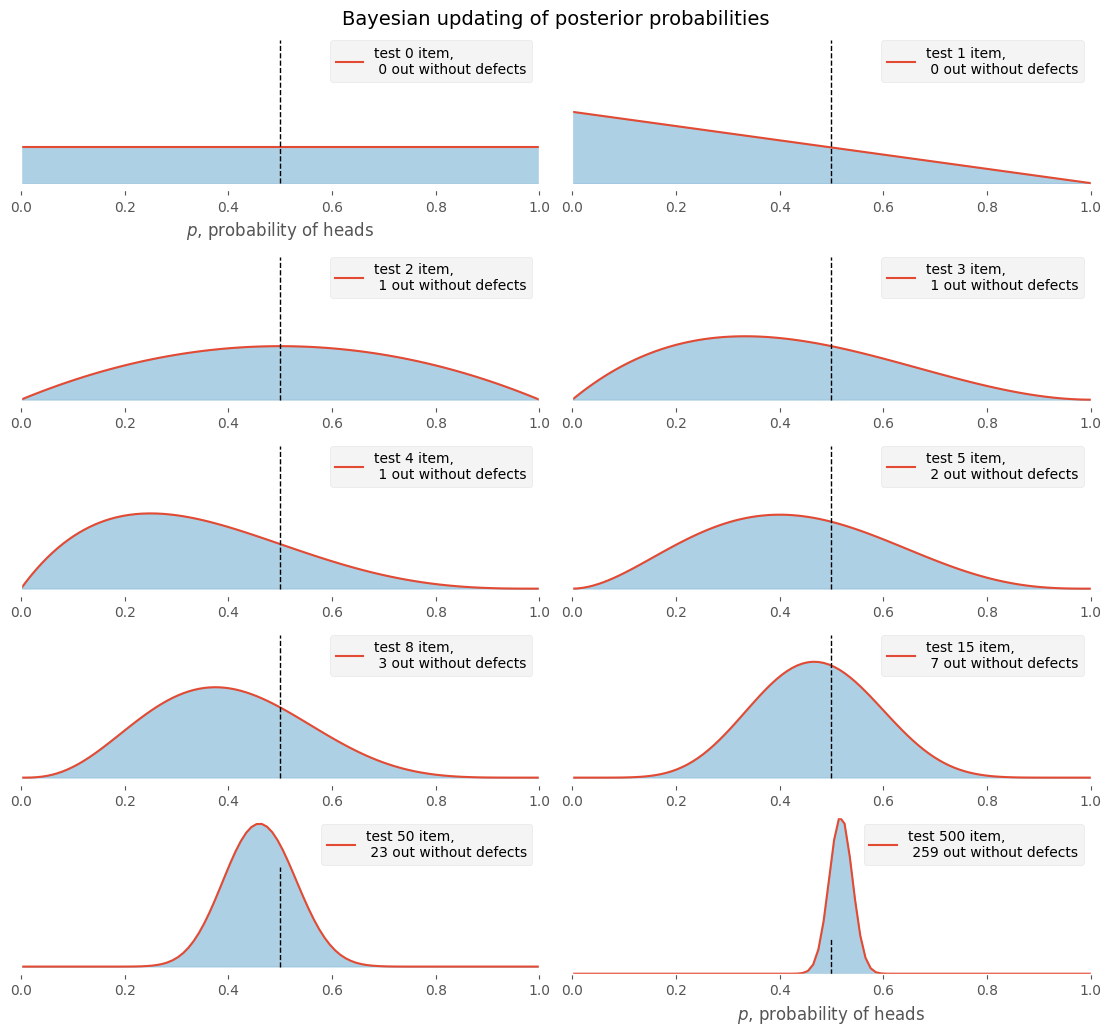

In [189]:
import scipy.stats as stats # needed for beta

n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = rng.binomial(p=0.5, n=1, size=500) 
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(11, 10), layout='constrained', nrows=5, ncols=2)
fig.set_facecolor("white")
fig.set_facecolor("white")

k = 0
for row in range(5):
    for column in range(2):
        ax[row][column].plot()
        ax[row][column].set_xlim(0, 1)
        # ax[row][column].set_ylim(0, 1)
        ax[row][column].set_facecolor("white")
        ax[row][column].set_xlabel("$p$, probability of heads") if k in [0, len(n_trials) - 1] else None

        N = n_trials[k]
        heads = data[:N].sum()
        y = stats.beta.pdf(x, 1 + heads, 1 + N - heads)

        ax[row][column].plot(x, y, label="test %d item,\n %d out without defects" % (N, heads))
        ax[row][column].fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        ax[row][column].vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

        leg = ax[row][column].legend()
        leg.get_frame().set_alpha(0.4)

        ax[row][column].yaxis.grid(True, color="lightgrey", linestyle="--")
        ax[row][column].xaxis.grid(False)
        ax[row][column].yaxis.set_visible(False)
        plt.autoscale(tight=True)
        k += 1
_ = fig.suptitle("Bayesian updating of posterior probabilities", y=1.02, fontsize=14)

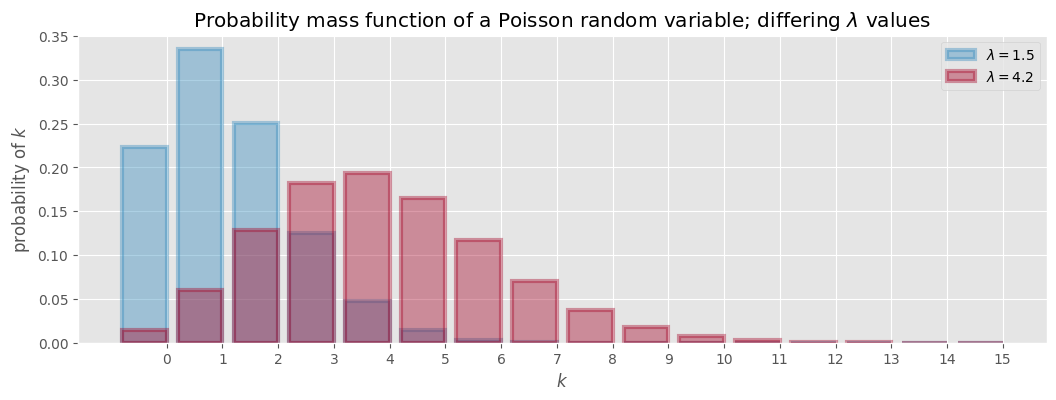

In [202]:
figsize(12.5, 4)

a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.40,
        edgecolor=colours[0], lw=3)

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.40,
        edgecolor=colours[1], lw=3)

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values");

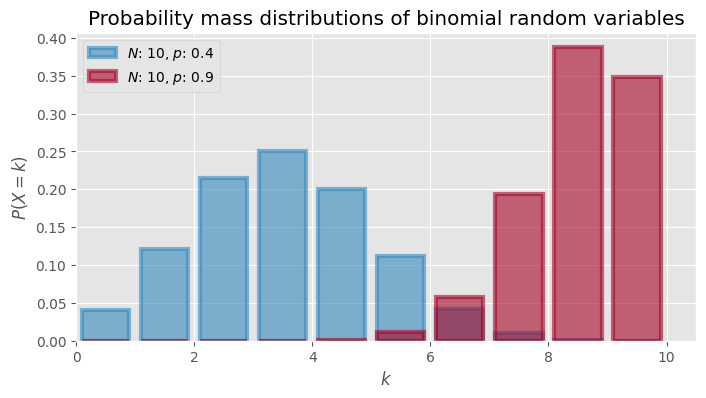

In [205]:
figsize(8, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

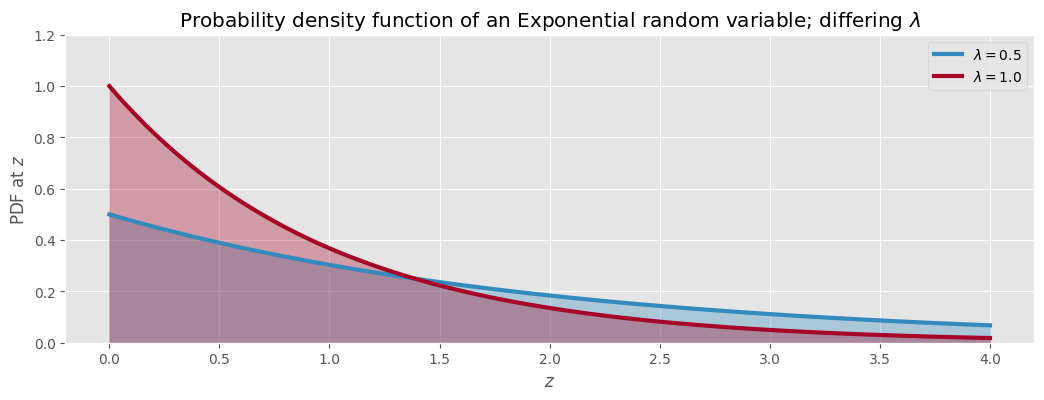

In [204]:
a = np.linspace(0, 4, 100)
lambda_ = [0.5, 1]
colours = ["#348ABD", "#A60628"]

for l, c in zip(lambda_, colours):
    plt.plot(a, stats.expon.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, stats.expon.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

## Detour into a few important ideas

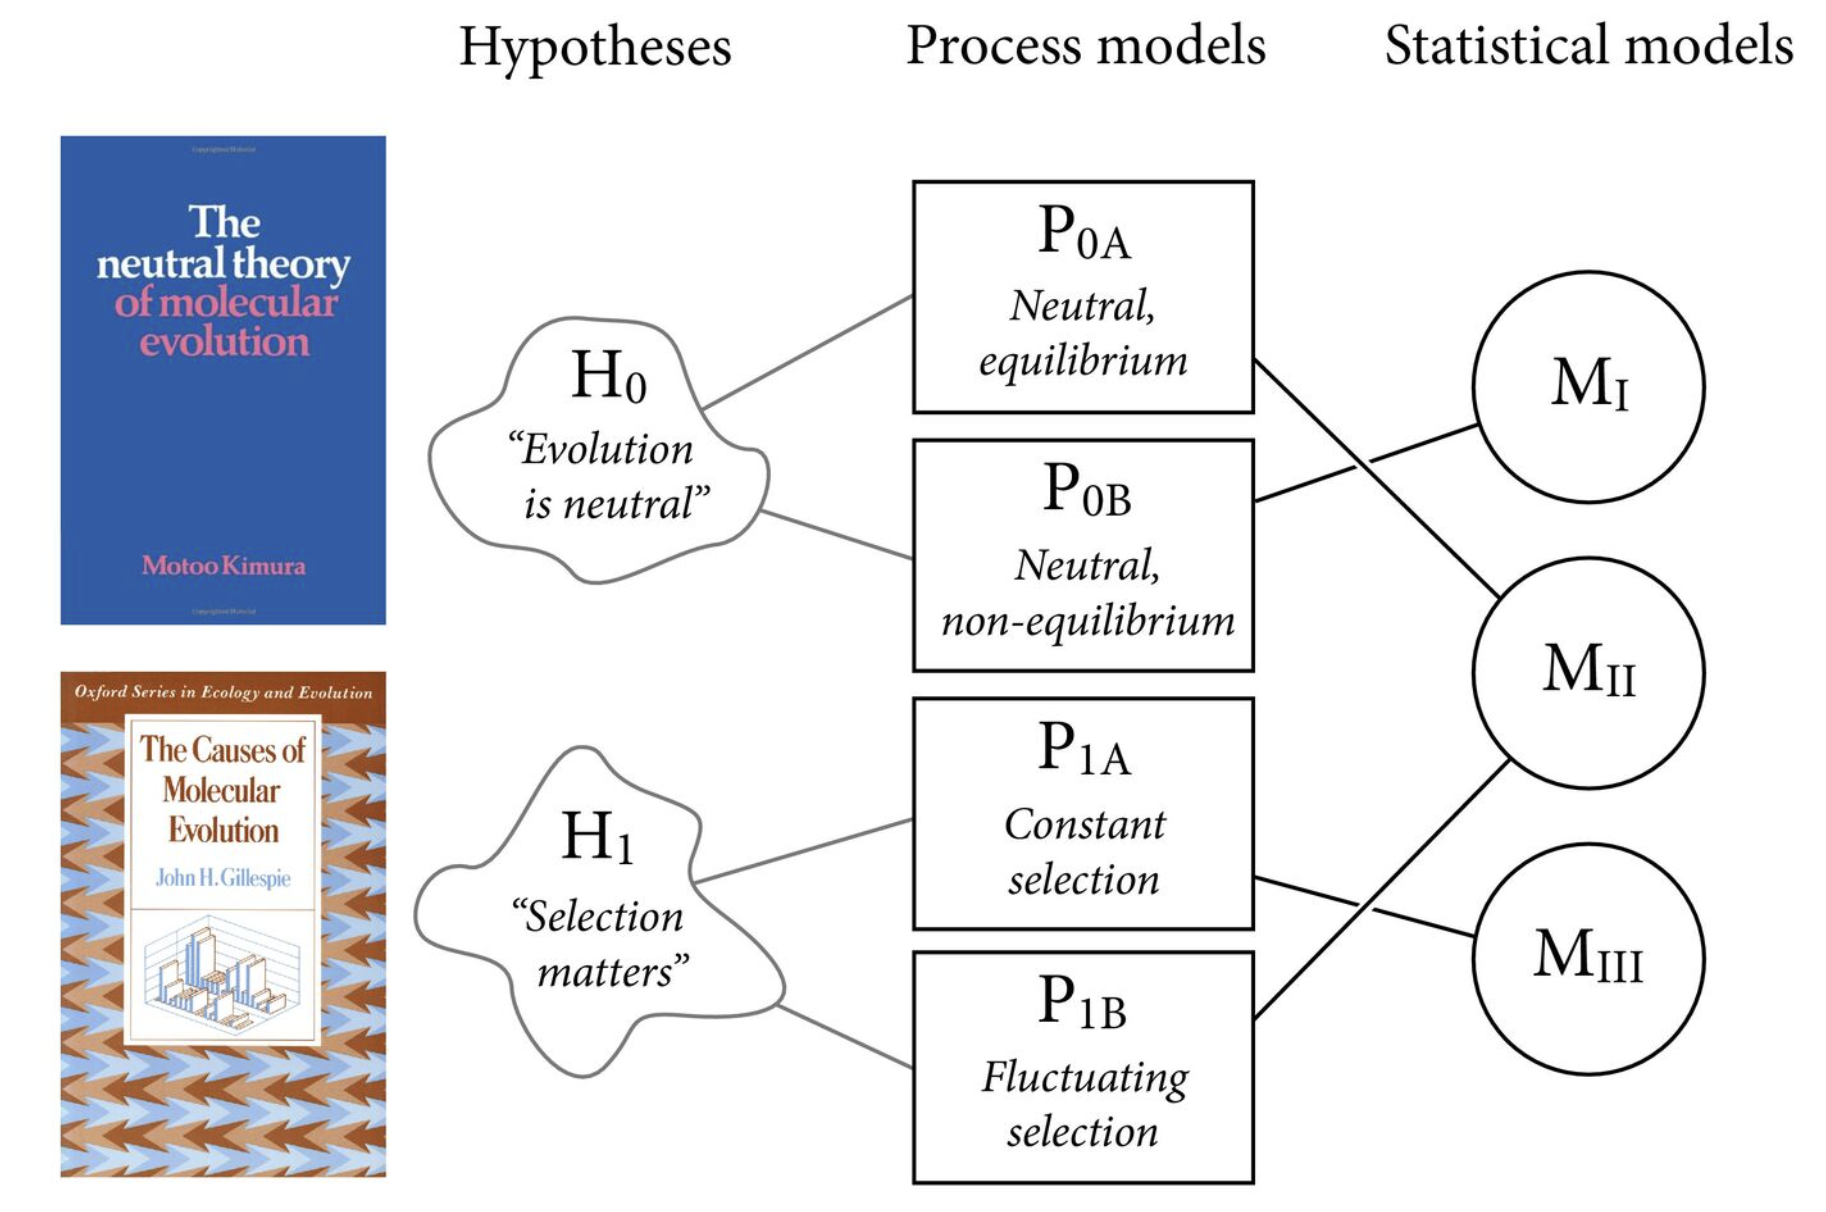

Source: Richard McElreath - Statistical Rethinking 2nd ed.


- Collectivity, Population, Sample
- Parameter, Estimator, Estimation
    - Note that, more generally, the it's not just a number (parameter), but an estimand (a research question), and sometimes it's not trivial to pin it down to a single quantity


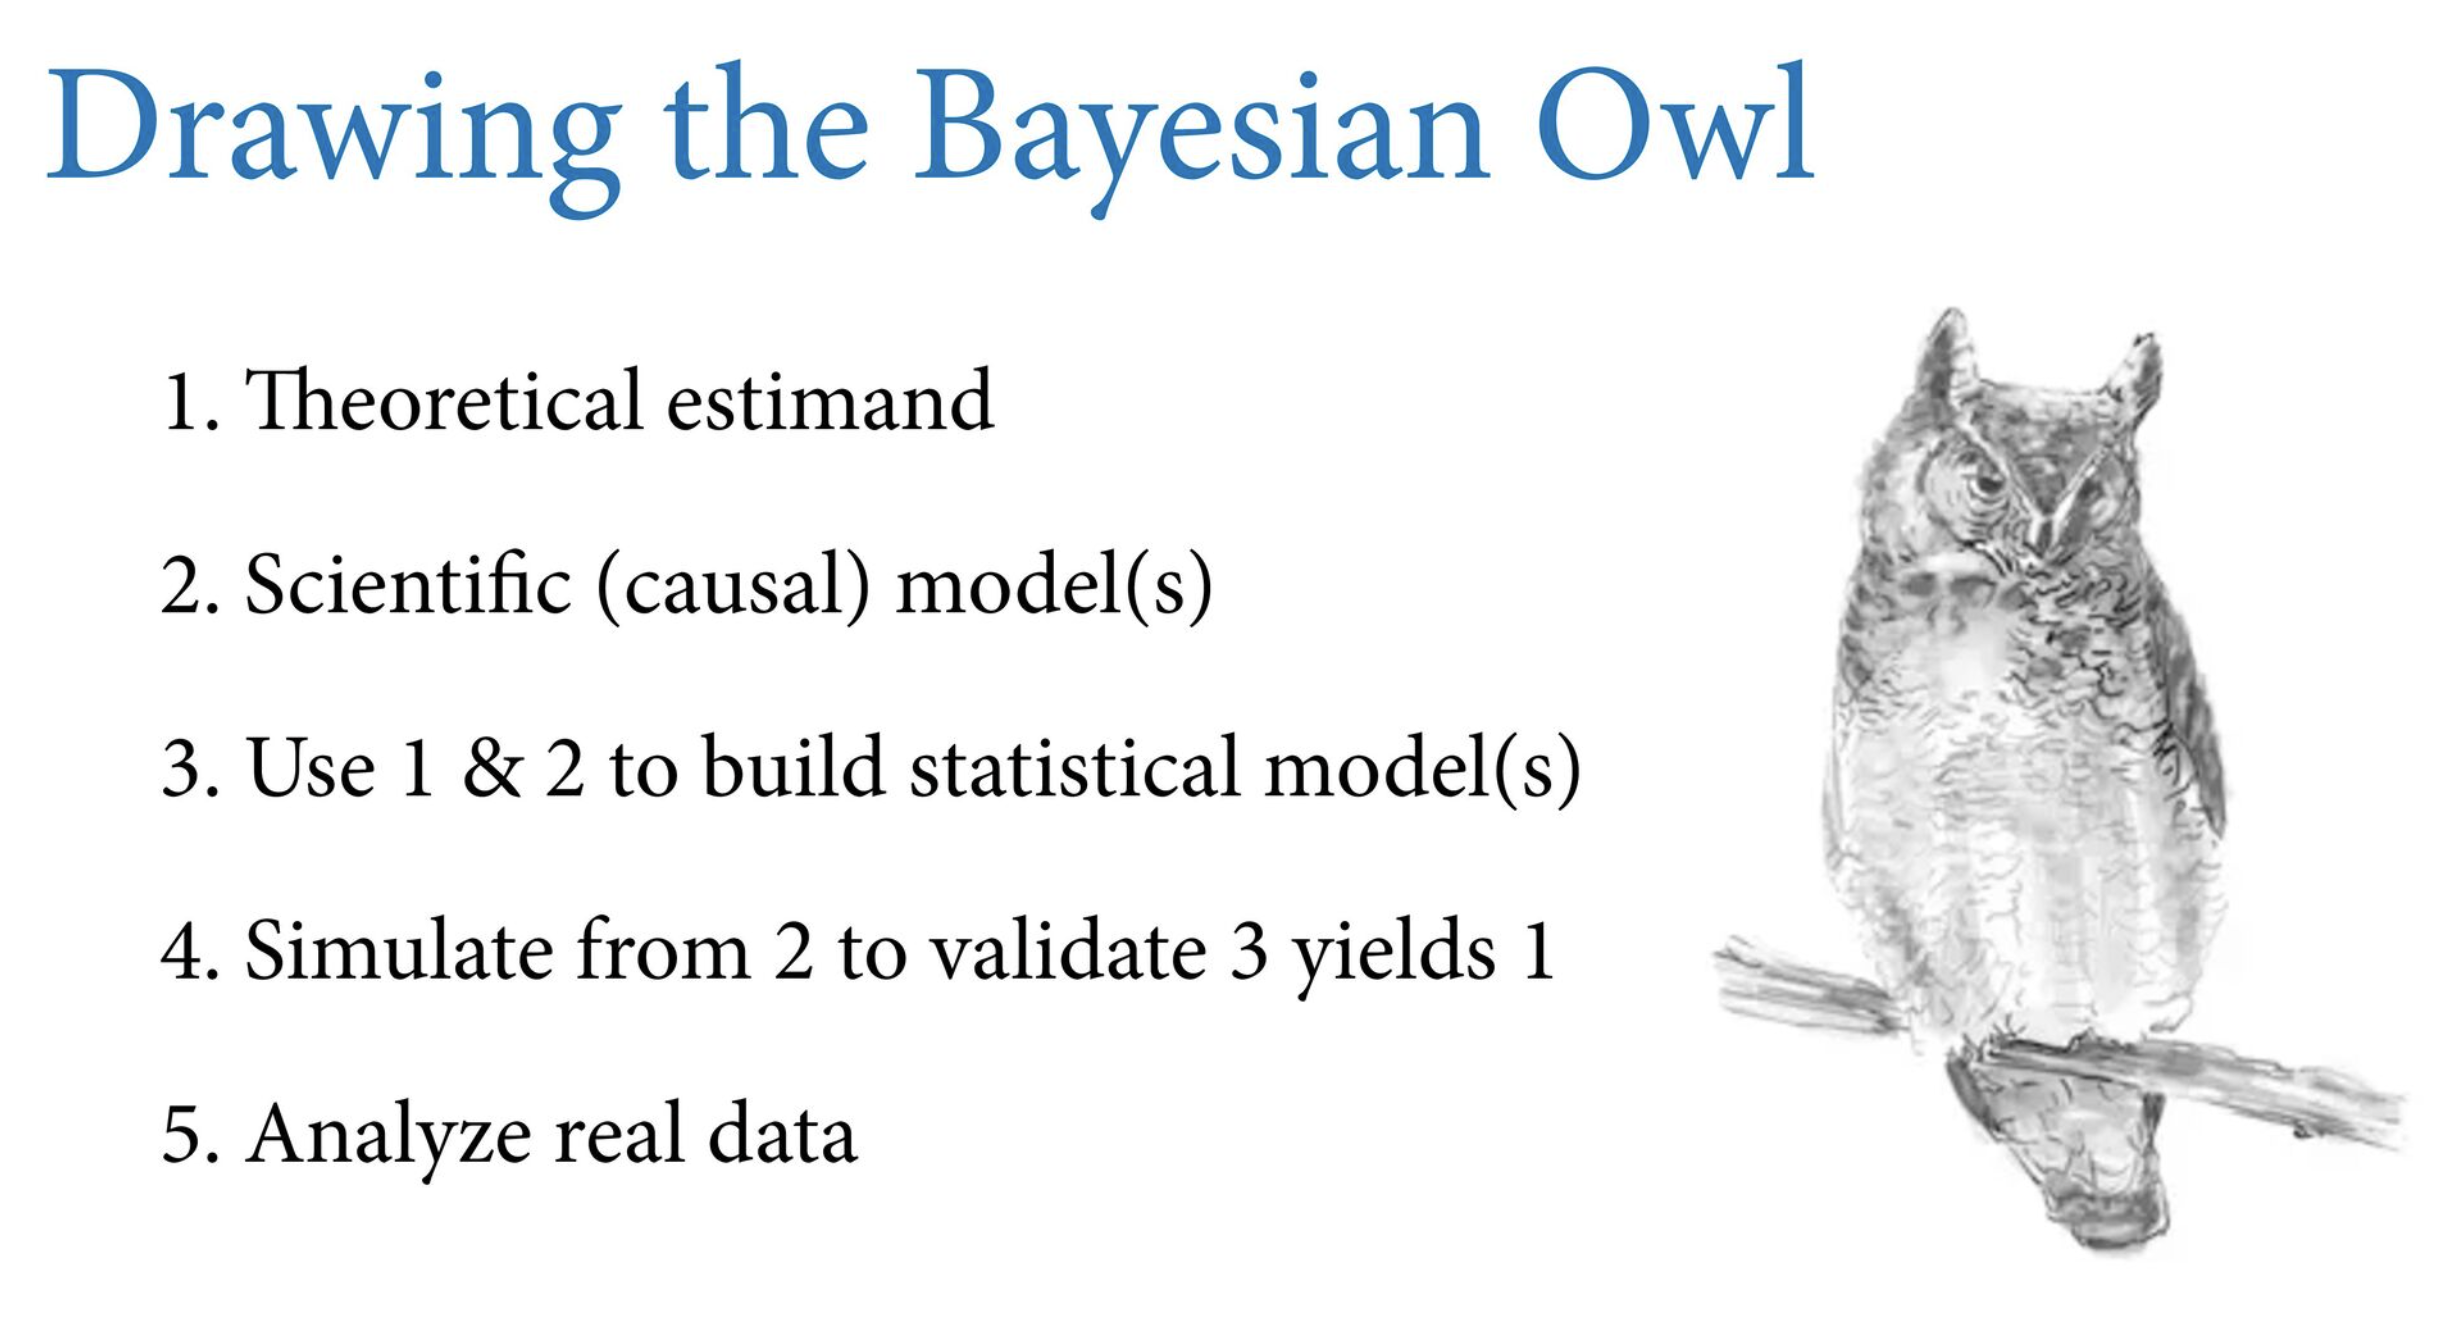

Source: Richard McElreath - Statistical Rethinking 2nd ed.


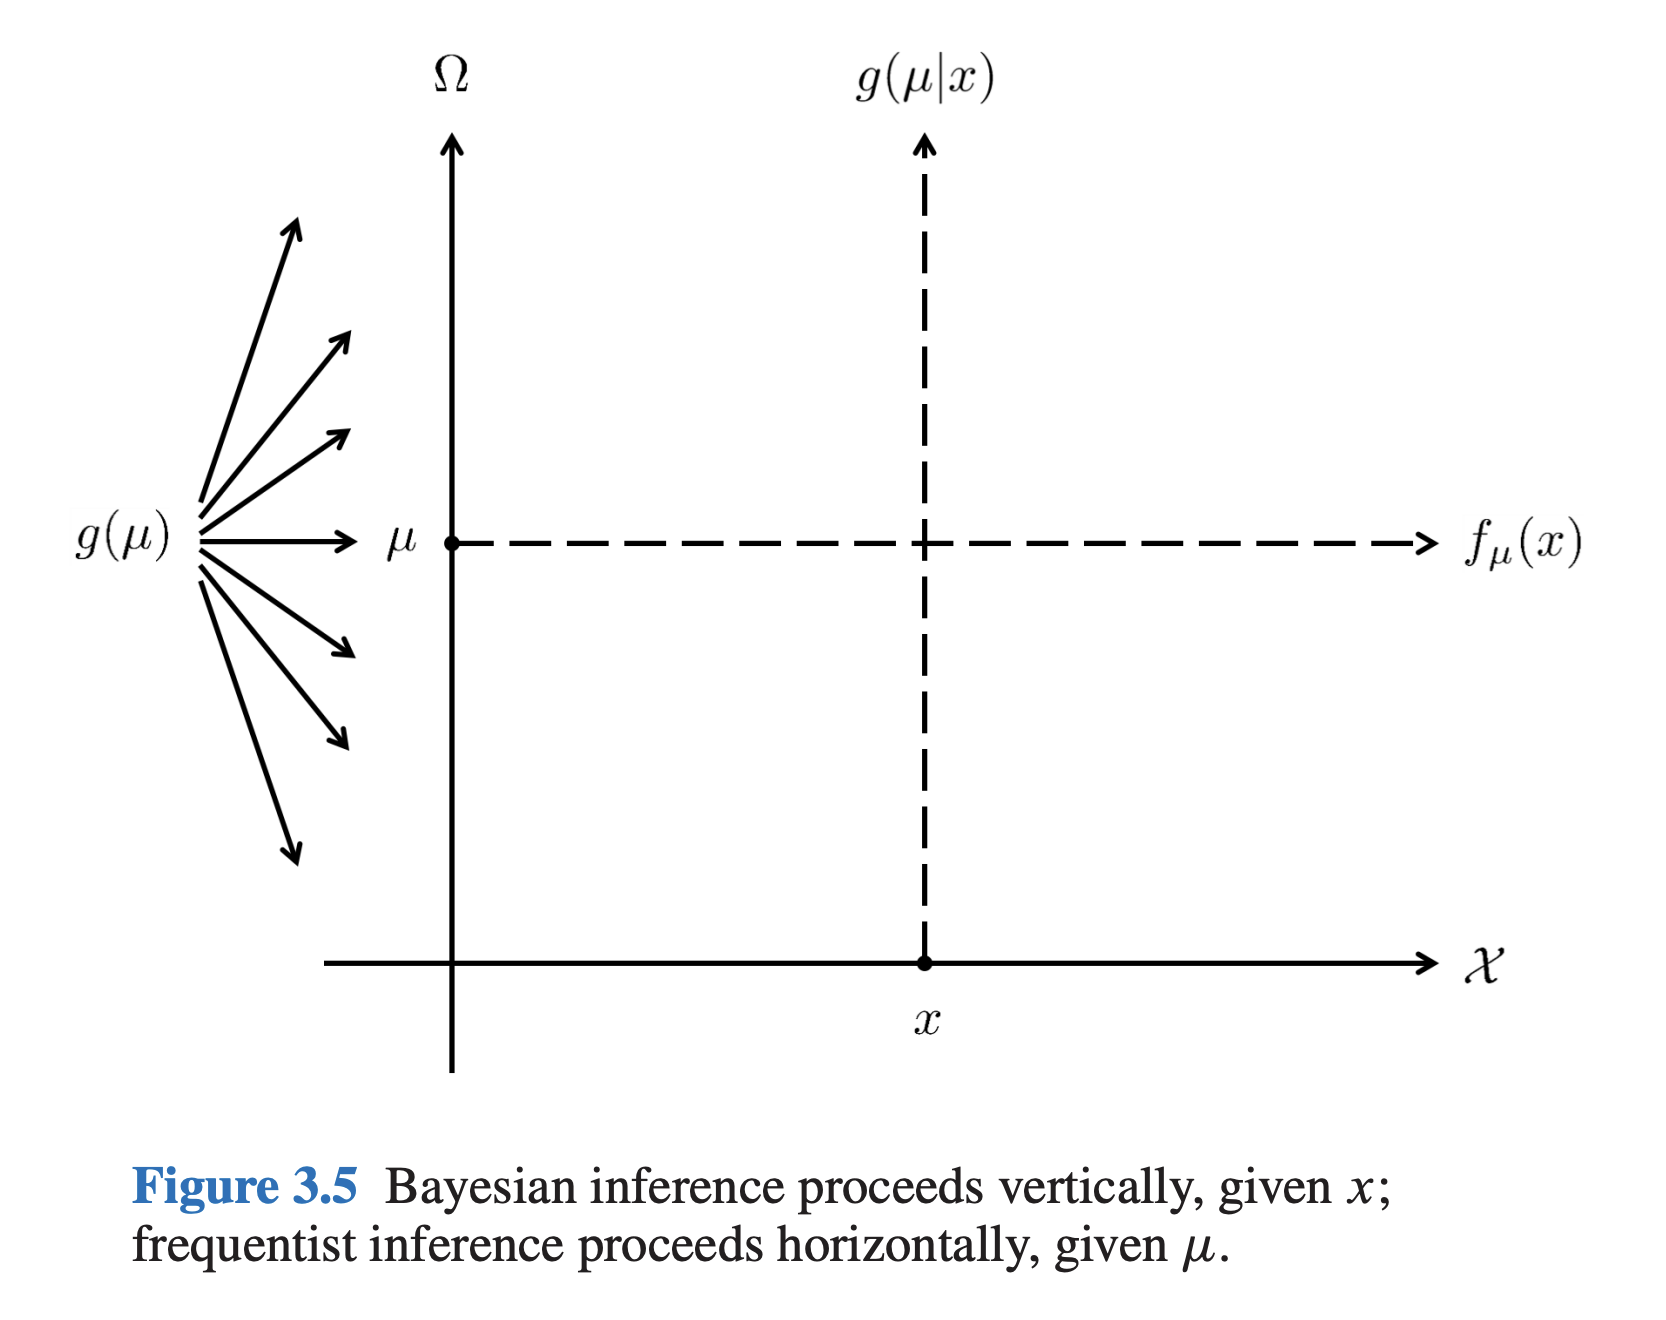

Source: Hastie, Efron - Computer Age Statistical Inference

## LLN and the Pitfalls of Small Groups
- why it is important for bayes, mcmc and in general, fundamental to stats

## CLT: "The most dangerous equation"

## Newsvendor Problem: Decisions Under Uncertainty

## Bayesian inference and pymc: prep for regression

- Give an analogy with Deep Learning: computational graphs, optimization (sampling)
- Poisson mixture, change point detection
- Galaxies: Finding galaxies' center example

## Poisson and NegBinom Regression

- overinflation
- generalized poisson

## Model comparison and overfitting

## Logistic and Multinomial Regression

- dirichlet

## Linear Regression and Robustness

- t distribution vs quantile regression
- Idea of regularization: Bayesian regression as Ridge
- LASSO (spike-and-slab variable selection)
- Categorical variables
- Nonlinear transformation (smoothers, kernels, splines zoo)

## Multidimensional stuff: Spike-and-Slab, Wishart

- interactions!

## A/B Testing and Experiment Design
- the bayesian way vs frequentist Neyman-Pearson way (lessons learned from the enemy)
- confusion matrix
- frequentist process
- estimators, CLT, LLN, properties
- bootstrap
- nonparametric tests
- bandits as an alternative

## Mixture models, clustering, and latent variable models

## Hierarchical Models

## Elements of causal inference

## Detour on the frequentist and Fisherian toolbox